In [1]:
import sys
sys.path.append('..')
import numpy as np
import pickle
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from NRC import NRC,RegularizedRF
from matplotlib.gridspec import GridSpec

from spatialFilters import *
from utils import *
from scipy.stats import zscore

In [2]:
srate = 240
expName = 'sweep'

dir = '../datasets/%s.pickle'% expName
winLENs = np.arange(0.2, 1, step=.2)
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)
    
sub = wholeset[3]
sub['name']

'shinanlin'

In [3]:
chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub['wn']['X'][:,chnINX]
y = sub['wn']['y']
S = np.stack([sub['wn']['STI'][i-1] for i in y])
X.shape

(960, 7, 240)

In [ ]:
from forwardModeling import ForwardModel
model = ForwardModel(sfreq=240,tmin=-0.1,tmax=0.4,estimator=10)

X = zscore(X,axis=-1)
S = zscore(S, axis=-1)
trainX, trainy, trainS = X[:100],y[:100],S[:100]
testX, testy, testS = X[-100:], y[-100:], S[-100:]
model.fit(S=trainS, R=trainX, y=trainy)

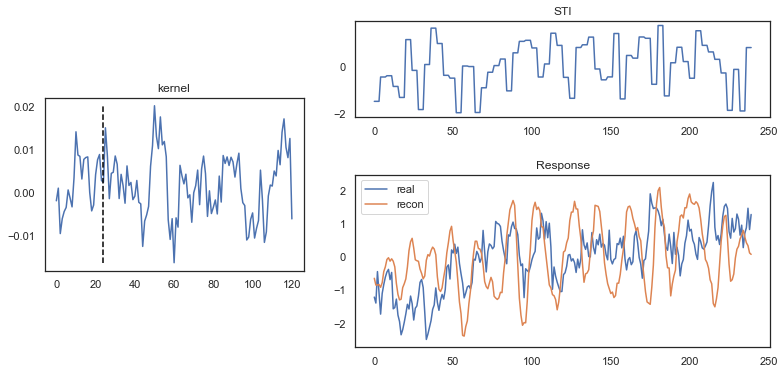

In [5]:
i = 0
tmin = 0.1

fig = plt.figure(figsize=(13, 6))
sns.set_theme(style='white')
plt.subplots_adjust(wspace=2, hspace=3)

row, column = 5, 10
con = 3
gs = GridSpec(row, column, figure=fig)
ax1 = fig.add_subplot(gs[1*row//5:4*row//5, :2*column//5])
ax2 = fig.add_subplot(gs[:2*row//5, 2*column//5:])
ax3 = fig.add_subplot(gs[2*row//5:5*row//5, 2*column//5:])


ax1.plot(model.trf)
ax1.vlines(x=int(tmin*240), ymin=model.trf.min(),
          ymax=model.trf.max(), colors='black', linestyles='dashed')
ax1.set_title('kernel')


ax2.plot(zscore(testS[i]))

ax2.set_title('STI')

r_ = model.predict(testS[i][np.newaxis,:])

ax3.plot(testX[i].mean(axis=0),label='real')
ax3.plot(zscore(r_.mean(axis=(0,1))), label='recon')
ax3.set_title('Response')

plt.legend()

In [5]:
rs = model.score(S=testS[:10],R=testX[:10])

In [ ]:

trainX, trainy, trainS = X[:20],y[:20],S[:20]
testX, testy, testS = X[-100:], y[-100:], S[-100:]

rs = np.zeros((len(np.arange(1, 10, step=1)),len(np.arange(-0.2, 0.2, step=0.1))))

for i,p in enumerate(np.arange(1,10,step=1)):

    for k,tmin in enumerate(np.arange(-0.2,0.2,step=0.1)):
        
        model = ForwardModel(sfreq=240,tmin=tmin,tmax=tmin+0.5,estimator=p)
        
        model.fit(S=trainS, R=trainX, y=trainy)
                
        r = model.score(S=testS[:10], R=testX[:10])

        rs[i,k] = r.mean()

# Evoked

In [ ]:
from forwardModeling import ForwardModel

X = sub['wn']['X'][:,chnINX]
y = sub['wn']['y']
S = np.stack([sub['wn']['STI'][i-1] for i in np.unique(y)])

sp = TRCA(srate=240,winLEN=1,montage=160,lag=0)
evoked = sp.fit_transform(X,y)

evoked = evoked.transpose((1,0,-1))
forward = ForwardModel(sfreq=240,tmin=0.05,tmax=0.4,estimator=10)
forward.fit(S=S, R=evoked, y=np.unique(y))

p_ = forward.predict(S=S)

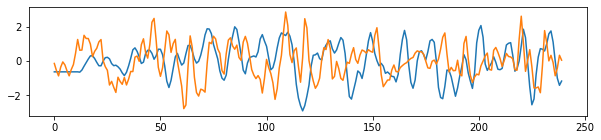

In [14]:

f,ax = plt.subplots(figsize=(10,2))
plt.plot(zscore(p_.mean(axis=1)[0]))
plt.plot(zscore(evoked[0, :].mean(axis=0)))

In [12]:
evoked.shape

(160, 5, 240)

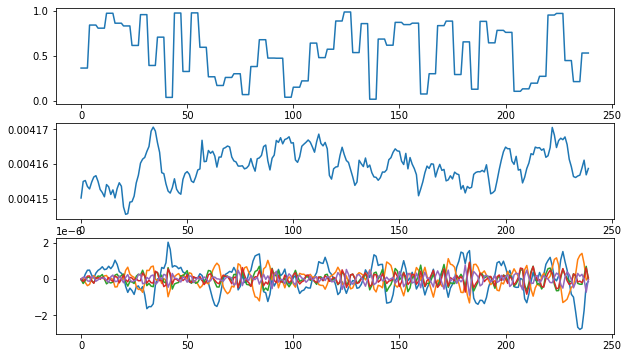

In [19]:
i = 1
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,6))

ax1.plot(S[i])
ax2.plot(X[y==i].mean(axis=(0,1)))
ax3.plot(evoked[i].T)

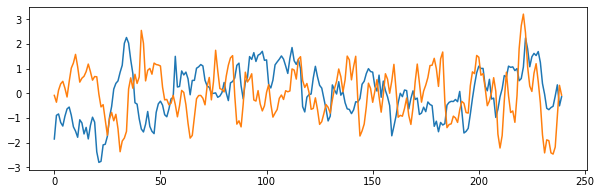

In [22]:
i = 1
f,ax1 = plt.subplots(1,1,figsize=(10,3))

ax1.plot(zscore(X[y==i].mean(axis=(0,1))))
ax1.plot(zscore(evoked[i].mean(axis=0)))

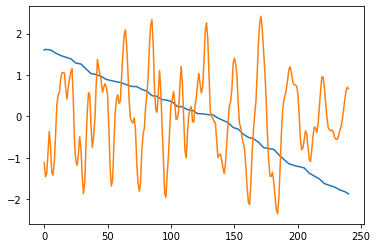

In [46]:
s = S[y==i].mean(axis=(0))
x1 = X[y==i].mean(axis=(0,1))
x2 = evoked[i]

c1 = np.correlate(x1,s,mode='full')
c2 = np.correlate(x2,s,mode='full')
plt.plot(zscore(c1[len(c1)//2-1:]))
plt.plot(zscore(c2[len(c2)//2-1:]))